# Which tree species should the city plant?

## 📖 Background
You work for a nonprofit organization advising the planning department on ways to improve the quantity and quality of trees in New York City. The urban design team believes tree size (using trunk diameter as a proxy for size) and health are the most desirable characteristics of city trees.

The city would like to learn more about which tree species are the best choice to plant on the streets of Manhattan.

## 💾 The data
The team has provided access to the 2015 tree census and geographical information on New York City neighborhoods ([trees](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh), [neighborhoods](https://data.cityofnewyork.us/City-Government/NTA-map/d3qk-pfyz)):

#### Tree Census
- "tree_id" - Unique id of each tree.
- "tree_dbh" - The diameter of the tree in inches measured at 54 inches above the ground.
- "curb_loc" - Location of the tree bed in relation to the curb. Either along the curb (OnCurb) or offset from the curb (OffsetFromCurb).
- "spc_common" - Common name for the species.
- "status" - Indicates whether the tree is alive or standing dead.
- "health" - Indication of the tree's health (Good, Fair, and Poor).
- "root_stone" - Indicates the presence of a root problem caused by paving stones in the tree bed.
- "root_grate" - Indicates the presence of a root problem caused by metal grates in the tree bed.
- "root_other" - Indicates the presence of other root problems.
- "trunk_wire" - Indicates the presence of a trunk problem caused by wires or rope wrapped around the trunk.
- "trnk_light" - Indicates the presence of a trunk problem caused by lighting installed on the tree.
- "trnk_other" - Indicates the presence of other trunk problems.
- "brch_light" - Indicates the presence of a branch problem caused by lights or wires in the branches.
- "brch_shoe" - Indicates the presence of a branch problem caused by shoes in the branches.
- "brch_other" - Indicates the presence of other branch problems.
- "postcode" - Five-digit zip code where the tree is located.
- "nta" - Neighborhood Tabulation Area (NTA) code from the 2010 US Census for the tree.
- "nta_name" - Neighborhood name.
- "latitude" - Latitude of the tree, in decimal degrees.
- "longitude" - Longitude of the tree, in decimal degrees.

#### Neighborhoods' geographical information
- "ntacode" - NTA code (matches Tree Census information).
- "ntaname" - Neighborhood name (matches Tree Census information).
- "geometry" - Polygon that defines the neighborhood.

_Tree census and neighborhood information from the City of New York [NYC Open Data](https://opendata.cityofnewyork.us/data/)._

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(sf))
suppressPackageStartupMessages(library(broom))
trees <- readr::read_csv('data/trees.csv', show_col_types = FALSE)
head(trees, 1);

tree_id,tree_dbh,curb_loc,spc_common,status,health,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,postcode,nta,nta_name,latitude,longitude
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
190422,11,OnCurb,honeylocust,Alive,Good,No,No,No,No,No,No,No,No,No,10023,MN14,Lincoln Square,40.77005,-73.98495


[1] "trees"

    borocode   boroname          countyfips          ntacode         
 Min.   :1   Length:195         Length:195         Length:195        
 1st Qu.:2   Class :character   Class :character   Class :character  
 Median :3   Mode  :character   Mode  :character   Mode  :character  
 Mean   :3                                                           
 3rd Qu.:4                                                           
 Max.   :5                                                           
   ntaname            shape_area          shape_leng              geometry  
 Length:195         Min.   :  5575232   Min.   : 11000   MULTIPOLYGON :195  
 Class :character   1st Qu.: 19383535   1st Qu.: 23824   epsg:NA      :  0  
 Mode  :character   Median : 32629833   Median : 30555   +proj=long...:  0  
                    Mean   : 43230625   Mean   : 42007                      
                    3rd Qu.: 50237361   3rd Qu.: 41873                      
                    Max.   :327762259   Max.   :

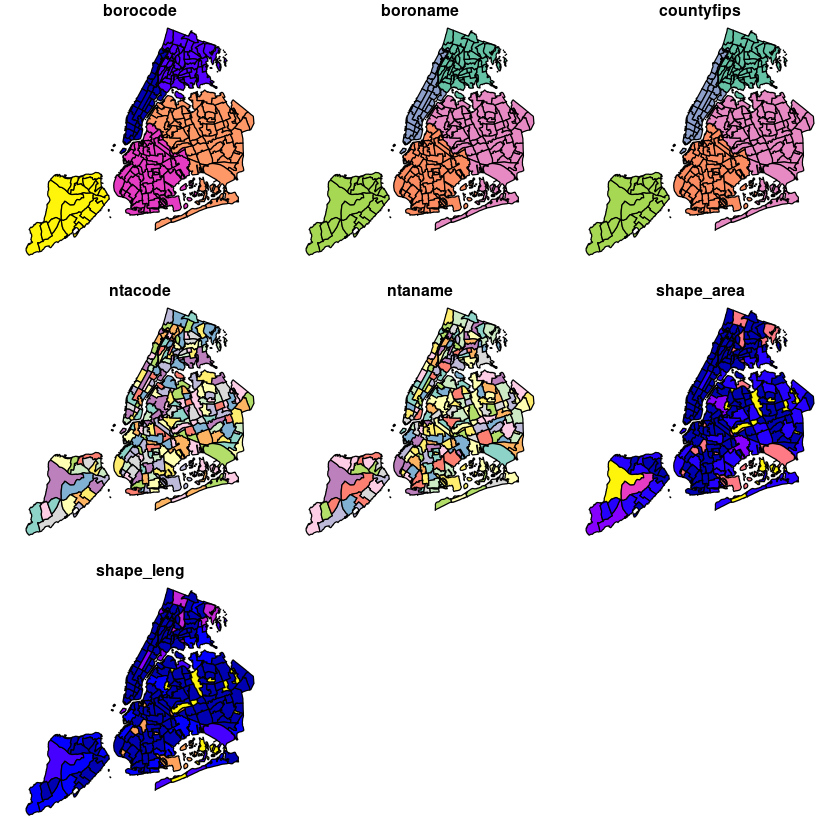

In [2]:
neighborhoods <- st_read("data/nta.shp", quiet=TRUE)
summary(neighborhoods)
plot(neighborhoods)

# What is most popular species among planted trees?

In [3]:
suppressWarnings(install.packages('ggsci'))
suppressWarnings(install.packages("wesanderson"))
# Load
suppressPackageStartupMessages(library(wesanderson))
suppressPackageStartupMessages(library(ggsci))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(gridExtra))

Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/ggsci_2.9.tar.gz' ...
	OK [downloaded 2.8 Mb in 0.2 secs]
Installing ggsci [2.9] ...
	OK [installed binary]
Moving ggsci [2.9] into the cache ...
	OK [moved to cache in 0.44 milliseconds]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/wesanderson_0.3.6.tar.gz' ...
	OK [downloaded 17 Kb in 0.4 secs]
Installing wesanderson [0.3.6] ...
	OK [installed binary]
Moving wesanderson [0.3.6] into the cache ...
	OK [moved to cache in 0.34 milliseconds]


Let's clean data from omitted data rows. 

In [4]:
trees_1<-na.omit(trees)

We see that in final version of data sample is free from died trees information. Because of absence of information on health and factors that support trees state these rows were abounded.

In [5]:
# Dead trees filtered
head(trees%>%
     filter(status=='Dead'), 3)

tree_id,tree_dbh,curb_loc,spc_common,status,health,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,postcode,nta,nta_name,latitude,longitude
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
188609,9,OnCurb,NA,Dead,NA,No,No,No,No,No,No,No,No,No,10075,MN32,Yorkville,40.77199,-73.95166
189412,7,OnCurb,NA,Dead,NA,No,No,No,No,No,No,No,No,No,10027,MN09,Morningside Heights,40.80798,-73.95965
173517,8,OnCurb,NA,Dead,NA,No,No,No,No,No,No,No,No,No,10014,MN23,West Village,40.73520,-74.00583


In [6]:
rbind(trees%>%
     filter(status=='Alive')%>%
     count(status),
trees%>%
     filter(status=='Dead')%>%
     count(status))%>%
     mutate(share = round(n*100/sum(n)))%>%
     mutate(number = n, share = share)%>%
     select(-n)%>%
     select(status, number, share)

status,number,share
<chr>,<int>,<dbl>
Alive,62427,97
Dead,1802,3


We have 3% of dead trees, but at the same time 97% are alive but with different health conditions.

In [7]:
species.1 <-
 trees_1%>%
    group_by(spc_common)%>%
    count(spc_common)%>%
    arrange(desc(n), by_group = T)%>%
    mutate(Total_Alive = n)%>%
    select(-n)


species.2 <- 
 trees_1%>%
    filter(health == "Good")%>%
    group_by(spc_common)%>%
    count(health)%>%
    arrange(desc(n), by_group = T)%>%
    # summarise_at(vars(n), sum) %>% 
    # bind_cols(. / colSums(.))%>%
    mutate(Healthy = n)%>%
    select(-n)
  
  species.3 <-
   trees_1%>%
    filter(health == "Fair")%>%
    group_by(spc_common)%>%
    count(health)%>%
    arrange(desc(n), by_group = T)%>%
    mutate(Fair = n)%>%
    select(-n)
    
   species.4 <-
    trees_1%>%
    filter(health == "Poor")%>%
    group_by(spc_common)%>%
    count(health)%>%
    arrange(desc(n), by_group = T)%>%
    mutate(Poor = n)%>%
    select(-n)
      
species<-cbind(species.1[1:10,], species.2[1:10,3], species.3[1:10,3], species.4[1:10,3])
species<-species %>%
    mutate(share_healthy = round(Healthy/Total_Alive*100), share_fair = round(Fair/Total_Alive*100), share_poor = round(Poor/Total_Alive*100))%>%
    arrange(desc(share_healthy),by_group=T)
        
    
species_names<-species$spc_common[1:10]

print(head(species, 10))

# A tibble: 10 × 8
# Groups:   spc_common [10]
   spc_common        Total_Alive Healthy  Fair  Poor share_hea…¹ share…² share…³
   <chr>                   <int>   <int> <int> <int>       <dbl>   <dbl>   <dbl>
 1 honeylocust             13175   10958  2012   491          83      15       4
 2 pin oak                  4584    3731   982   381          81      21       8
 3 Sophora                  4453    3554   796   205          80      18       5
 4 American elm             1698    1361   379   134          80      22       8
 5 ginkgo                   5859    4386  1144   441          75      20       8
 6 Callery pear             7297    5382  1474   461          74      20       6
 7 Japanese zelkova         3596    2597   713   186          72      20       5
 8 London planetree         4122    2773   719   204          67      17       5
 9 American linden          1583    1020   266    78          64      17       5
10 littleleaf linden        3333    2076   619   184          

In [8]:
head(species_names_wide<-cbind(sort(unique(trees$spc_common))))

'Schubert' chokecherry
American beech
American elm
American hophornbeam
American hornbeam
American larch


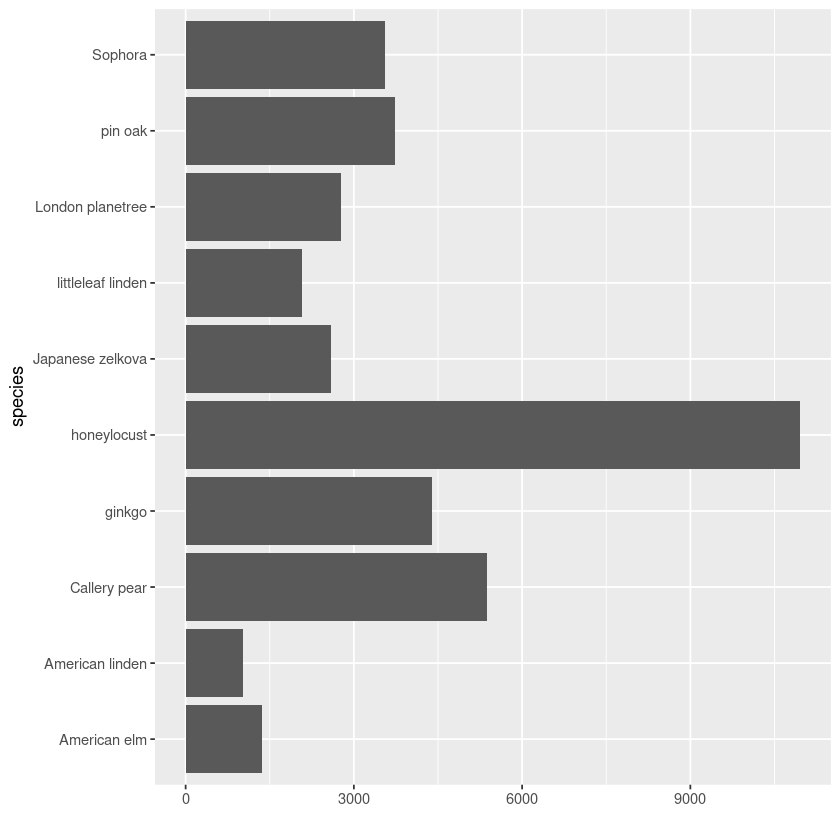

In [9]:
# with(species, reorder(spc_common, quantity))
# with(species, reorder(spc_common, Healthy))
p1<- ggplot(data = species%>%arrange(desc(Healthy), by_group = T), aes(x = Healthy, y = spc_common )) + geom_col()+ labs( x = '', y = 'species' )
    p1<- ggplot(data = species%>%arrange(desc(Healthy), by_group = T))+geom_bar(aes(x = Healthy, y = spc_common), stat = 'identity' ) +  labs( x = '', y = 'species' )
  ## change plot appearance
  p1+ggsci::scale_fill_lancet(palette = c("lanonc"), alpha = .5)+
    scale_color_lancet(palette = c('lanonc'))
    

From previous table it's obvious that the most frequently recorded in data series was honeylocust tree. Let see its distribution by neighborhoods.

We see that honeylocust is very widespreaded across neighborhood# A tibble: 28 × 2
# Groups:   nta_name [28]
   nta_name                                       n
   <chr>                                      <int>
 1 Upper West Side                              972
 2 Lenox Hill-Roosevelt Island                  776
 3 Upper East Side-Carnegie Hill                725
 4 Yorkville                                    680
 5 Clinton                                      649
 6 Central Harlem North-Polo Grounds            640
 7 Turtle Bay-East Midtown                      635
 8 Washington Heights South                     601
 9 Hudson Yards-Chelsea-Flatiron-Union Square   572
10 West Village                                 560
# … with 18 more rows


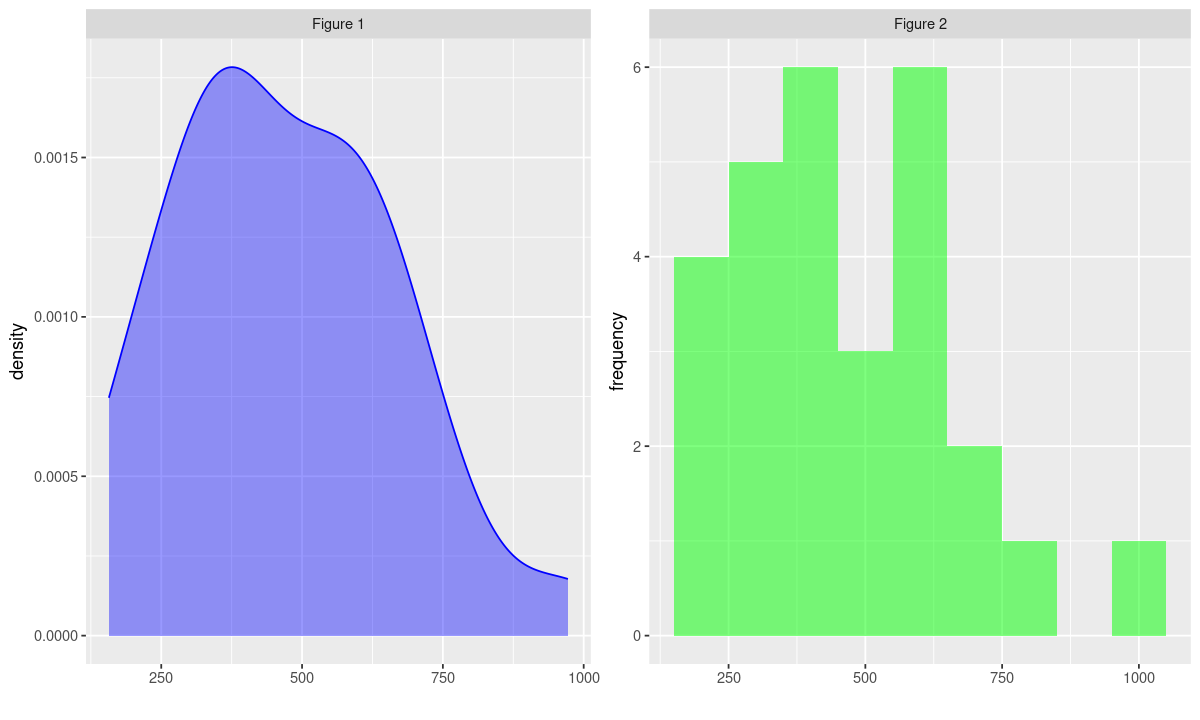

In [10]:
honeylocust<-trees%>%
    filter(spc_common == "honeylocust")%>%
    group_by(nta_name)%>%
    count(nta_name)%>%
    arrange(desc(n), by_group = T)
cat(paste('We see that honeylocust is very widespreaded across neighborhood'))
print(honeylocust)

options(repr.plot.width = 10, repr.plot.height = 6)
facets<-c('Figure 1', 'Figure 2')
p2<-ggplot(honeylocust, aes(x = n))+
    geom_density(fill = 'blue',alpha = .4, color = 'blue')+labs(x='')+facet_wrap(facets[1]~.)# + scale_fill_manual(values=wes_palette(n=3, name="Zissou"))

p3<-ggplot(honeylocust, aes(x = n))+
    geom_histogram(binwidth = 1000/10, fill = 'green1', alpha = .5)+facet_wrap(facets[2]~.)+labs(x='', y='frequency') #+ #scale_fill_manual(values=wesanderson::wes_palette(n=3, name="Zissou"))+scale_color_manual(values=wes_palette(n=3, name="Zissou"))
grid.arrange(p2, p3, ncol = 2)

# Which are the neighborhoods with the most trees?

In [12]:
# Number of all trees
head(trees%>%
    mutate(NTA = nta_name)%>%
    group_by(NTA)%>%
    count(NTA)%>%
    mutate(Number_of_trees = n)%>% 
    arrange(desc(Number_of_trees), by_group=T)%>%
    select(-n))

New names:
• `` -> `...1`


NTA,Number_of_trees
<chr>,<int>
Upper West Side,5807
Upper East Side-Carnegie Hill,4616
West Village,3801
Central Harlem North-Polo Grounds,3469
Hudson Yards-Chelsea-Flatiron-Union Square,2931
Washington Heights South,2924


In [13]:
# Distribution across the neighborhoods alive trees
head(trees_1%>%
    mutate(NTA = nta_name)%>%
    group_by(NTA)%>%
    count(NTA)%>%
    mutate(Number_of_trees = n)%>%
    arrange(desc(Number_of_trees), by_group = T)%>%
    select(-n), 10)

New names:
• `` -> `...1`


NTA,Number_of_trees
<chr>,<int>
Upper West Side,5723
Upper East Side-Carnegie Hill,4540
West Village,3715
Central Harlem North-Polo Grounds,3355
Hudson Yards-Chelsea-Flatiron-Union Square,2797
Washington Heights South,2788
Morningside Heights,2642
Central Harlem South,2581
Washington Heights North,2519


Thus the Upper West Side has the most planted trees. Let's plot this.

In [14]:
suppressMessages(install.packages('rgdal'))
suppressMessages(install.packages('leaflet'))
suppressPackageStartupMessages(require(rgdal))
suppressPackageStartupMessages(require(leaflet))

my_shp <- suppressWarnings(readOGR( 
  dsn= paste0(getwd(),"/data/nta.shp") , 
  verbose=FALSE
))
names(my_shp)
suppressPackageStartupMessages(require(broom))
shp_fortified<-tidy(my_shp, region = 'ntaname')
head(shp_fortified)


Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/rgdal_1.6-3.tar.gz' ...
	OK [downloaded 4.7 Mb in 0.1 secs]
Installing rgdal [1.6-3] ...
	OK [installed binary]
Moving rgdal [1.6-3] into the cache ...
	OK [moved to cache in 0.34 milliseconds]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/leaflet_2.1.1.tar.gz' ...
	OK [downloaded 2.2 Mb in 0.5 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/viridis_0.6.2.tar.gz' ...
	OK [downloaded 2.9 Mb in 0.6 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/leaflet.providers_1.9.0.tar.gz' ...
	OK [downloaded 46.1 Kb in 0.3 secs]
Installing viridis [0.6.2] ...
	OK [installed binary]
Moving viridis [0.6.2] into the cache ...
	OK [moved to cache in 0.37 milliseconds]
Installing leaflet.providers [1.9.0] ...
	OK [installed binary]
Moving leaflet.providers [1.9.0] into the cache ...
	OK [moved 

[1] "borocode"   "boroname"   "countyfips" "ntacode"    "ntaname"   
[6] "shape_area" "shape_leng"

long,lat,order,hole,piece,group,id
<dbl>,<dbl>,<int>,<lgl>,<fct>,<fct>,<chr>
-73.82503,40.66358,1,FALSE,1,Airport.1,Airport
-73.82486,40.66358,2,FALSE,1,Airport.1,Airport
-73.82427,40.66358,3,FALSE,1,Airport.1,Airport
-73.82305,40.66355,4,FALSE,1,Airport.1,Airport
-73.81792,40.66296,5,FALSE,1,Airport.1,Airport
-73.81497,40.66247,6,FALSE,1,Airport.1,Airport


Let's find out in which neighbourhoods were planted trees. There are 28 neighbourhoods.

In [15]:
shp_filtered<-neighborhoods%>%
    filter(neighborhoods$ntaname %in% unique(trees$nta_name))
nrow(shp_filtered)

[1] 28

In [16]:
#Distribution of trees among neighborhoods
species_2<-
    trees_1%>%
    group_by(nta_name,spc_common)%>%
    count(spc_common)%>%
    arrange(desc(n), by_group= T)

head(species_2,3)
#Distribution of trees with good health in each neighborhood
species_3<-
    trees_1%>%
    group_by(nta_name,spc_common, health)%>%
    count(spc_common,health)%>%
    arrange(desc(n), by_group= T)

head(species_3,3)
#Counted healthy trees among each species.
species_gen<-
    trees_1%>%
    group_by(spc_common, health)%>%
    count(spc_common)%>%
    arrange(desc(n), by_group = T)

head(species_gen,3) 

New names:
• `` -> `...1`


nta_name,spc_common,n
<chr>,<chr>,<int>
Upper West Side,honeylocust,972
Upper East Side-Carnegie Hill,Callery pear,828
Upper West Side,pin oak,809


New names:
• `` -> `...1`


nta_name,spc_common,health,n
<chr>,<chr>,<chr>,<int>
Upper West Side,honeylocust,Good,900
Upper West Side,pin oak,Good,730
Upper East Side-Carnegie Hill,honeylocust,Good,627


New names:
• `` -> `...1`


spc_common,health,n
<chr>,<chr>,<int>
honeylocust,Good,10958
Callery pear,Good,5382
ginkgo,Good,4386


Lets visualize the location of trees and neighborhoods.
For that lets gather some data in one table. 

In [17]:
head(species_2, 1)

New names:
• `` -> `...1`


nta_name,spc_common,n
<chr>,<chr>,<int>
Upper West Side,honeylocust,972


In [18]:
map_data<-
species_2 %>% 
    left_join(neighborhoods, by = c ('nta_name'='ntaname'))%>%
    mutate(number_species = n)%>%
    select(-n)

head(map_data, 1)

map_data<-
trees_1 %>%
    right_join(neighborhoods, by = c('nta_name' = 'ntaname'))

head(map_data, 1)

New names:
• `` -> `...1`


nta_name,spc_common,borocode,boroname,countyfips,ntacode,shape_area,shape_leng,geometry,number_species
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<MULTIPOLYGON [°]>,<int>
Upper West Side,honeylocust,1,Manhattan,061,MN12,34381053,29158.13,MULTIPOLYGON (((-73.96003 4...,972


tree_id,tree_dbh,curb_loc,spc_common,status,health,root_stone,root_grate,root_other,trunk_wire,⋯,nta_name,latitude,longitude,borocode,boroname,countyfips,ntacode,shape_area,shape_leng,geometry
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<MULTIPOLYGON [°]>
190422,11,OnCurb,honeylocust,Alive,Good,No,No,No,No,⋯,Lincoln Square,40.77005,-73.98495,1,Manhattan,061,MN14,15805668,19866.05,MULTIPOLYGON (((-73.975 40....


In [33]:
mapdata<-
    map_data%>%
    group_by(spc_common , nta_name, geometry, shape_area, shape_leng)%>%
    arrange(as.factor(spc_common))

head(mapdata)

New names:
• `` -> `...1`


tree_id,tree_dbh,curb_loc,spc_common,status,health,root_stone,root_grate,root_other,trunk_wire,⋯,nta_name,latitude,longitude,borocode,boroname,countyfips,ntacode,shape_area,shape_leng,geometry
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<MULTIPOLYGON [°]>
135812,4,OnCurb,'Schubert' chokecherry,Alive,Fair,No,No,No,No,⋯,East Harlem North,40.80376,-73.93211,1,Manhattan,061,MN34,24495420,30603.26,MULTIPOLYGON (((-73.92719 4...
147349,3,OnCurb,'Schubert' chokecherry,Alive,Good,No,Yes,No,No,⋯,Midtown-Midtown South,40.74870,-73.99479,1,Manhattan,061,MN17,30192057,27035.74,MULTIPOLYGON (((-73.97301 4...
147348,4,OnCurb,'Schubert' chokecherry,Alive,Good,No,Yes,No,No,⋯,Midtown-Midtown South,40.74871,-73.99483,1,Manhattan,061,MN17,30192057,27035.74,MULTIPOLYGON (((-73.97301 4...
156380,3,OnCurb,'Schubert' chokecherry,Alive,Good,No,No,No,No,⋯,East Harlem South,40.78670,-73.94680,1,Manhattan,061,MN33,16650738,18625.04,MULTIPOLYGON (((-73.93505 4...
125571,4,OnCurb,'Schubert' chokecherry,Alive,Good,Yes,No,No,No,⋯,East Harlem North,40.80278,-73.94370,1,Manhattan,061,MN34,24495420,30603.26,MULTIPOLYGON (((-73.92719 4...
156826,4,OnCurb,'Schubert' chokecherry,Alive,Fair,Yes,No,No,No,⋯,East Harlem South,40.78805,-73.94832,1,Manhattan,061,MN33,16650738,18625.04,MULTIPOLYGON (((-73.93505 4...


# A visualization of Manhattan's neighborhoods and tree locations.

Installing devtools [2.4.5] ...
	OK [linked cache]


kelly_green,#29BF12
rich_electric_blue,#00A5CF
maximum_red,#DE1A1A
majorelle_blue,#574AE2
fluorescent_orange,#FFBF00


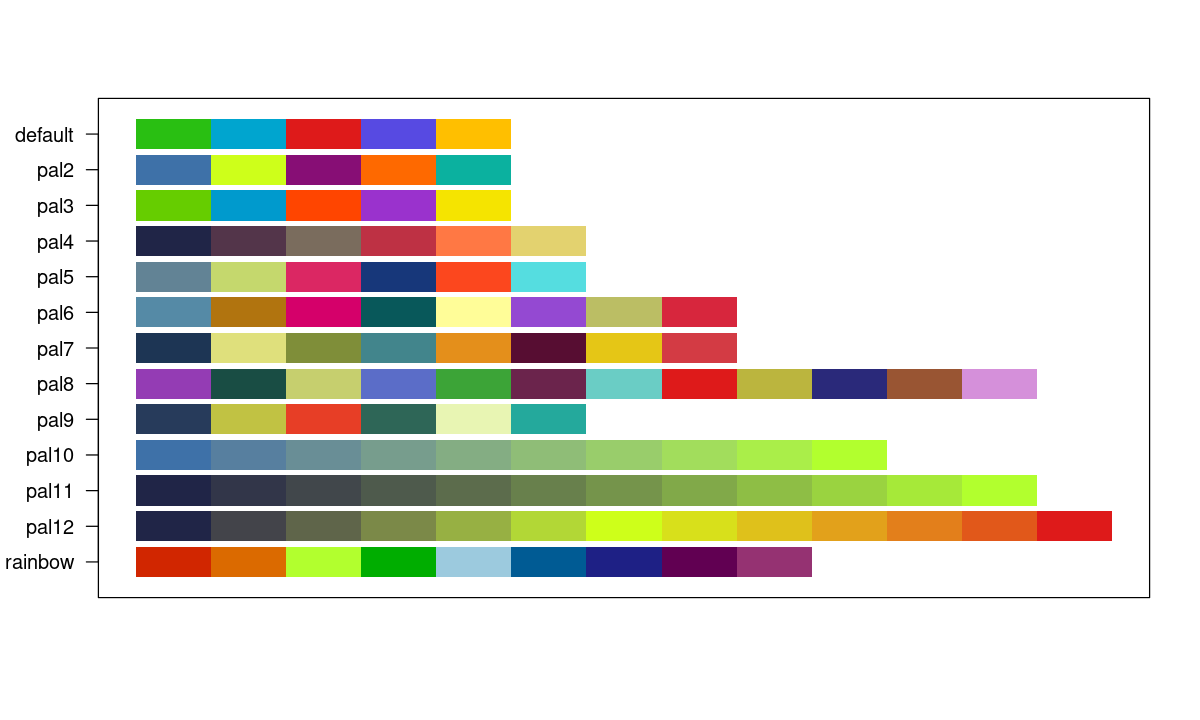

In [36]:
suppressMessages(install.packages("devtools"))
suppressMessages(devtools::install_github("jaredhuling/jcolors"))
suppressPackageStartupMessages(library(jcolors))

cbind(jcolors('default'))
# display_all_jcolors()

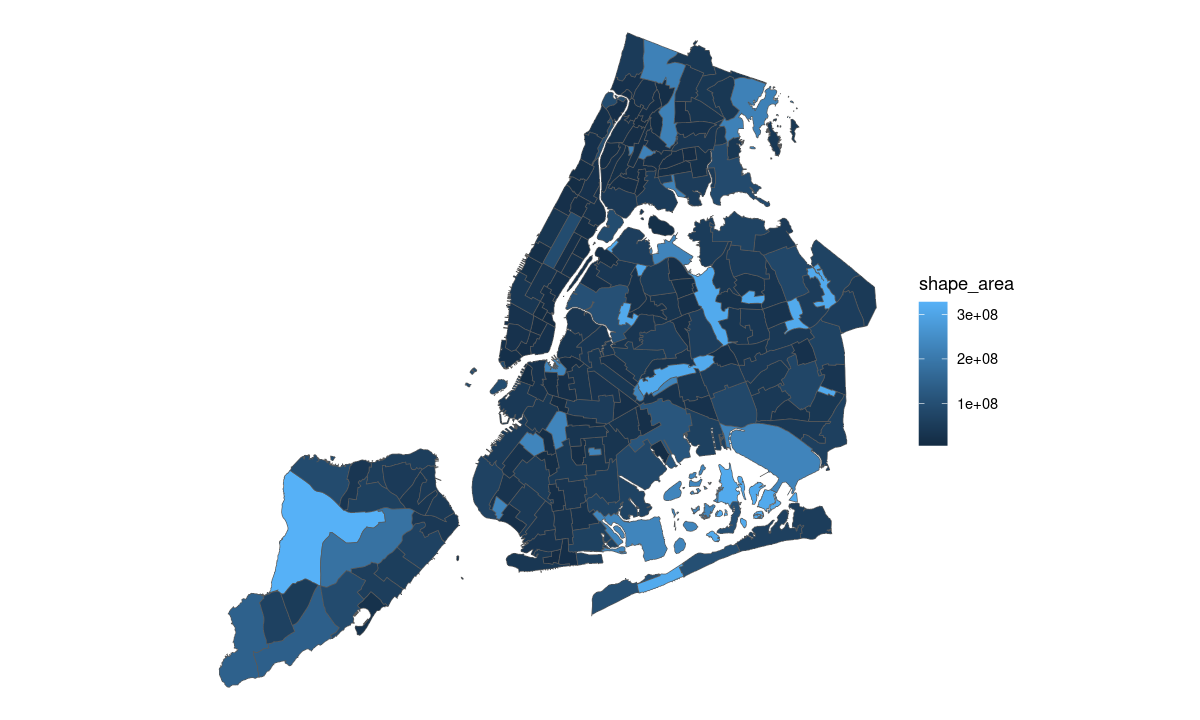

In [21]:
library(ggplot2)
p4<- ggplot(neighborhoods) +
  geom_sf(data = neighborhoods, aes( fill =  shape_area))  + theme_void() + scale_color_jcolors(palette = "default")
p4

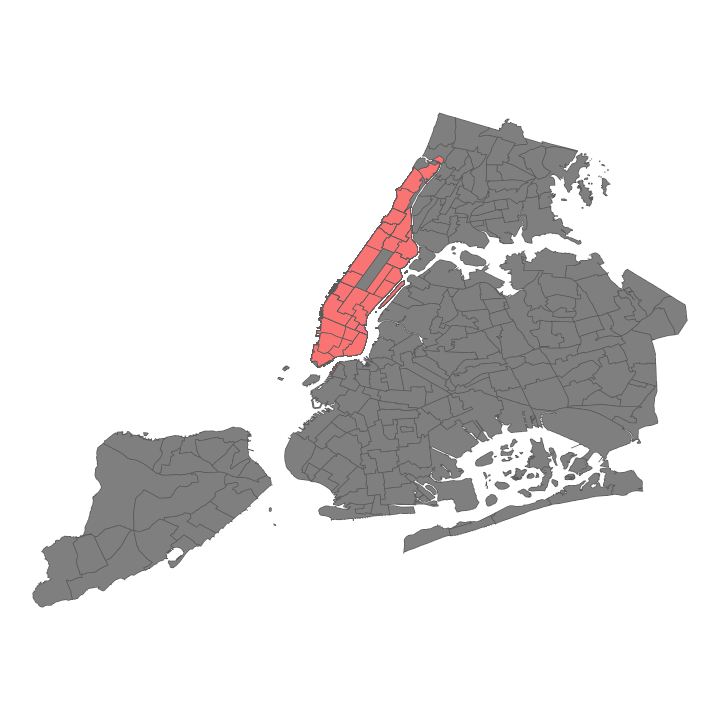

In [41]:
library(ggplot2)
options(repr.plot.width = 6, repr.plot.height = 6)

p5<- ggplot(mapdata) +
  geom_sf(data = mapdata, aes(fill = spc_common, geometry = geometry)) +
  theme_void() + scale_color_jcolors(palette = "default") + theme(legend.position='none')
p5

# What ten tree species should the city plant in the future?

For determining top-3 tree species we will use logit-regression toolkit. First of all let's choose predictors. 

In [43]:
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(stats))

In [ ]:
# load('Trees.jupyterlab-workspace')

In [42]:
# Let's make predictors' table 
trees_1->df
# code factor variables into binary 0 & 1.
df.2<-df%>%
  mutate(curb_loc = if_else(curb_loc == 'OnCurb', 1, 0),
         good_health = if_else(health=="Good", 1, 0), fair_health = if_else(health=="Fair", 1, 0), 
        poor_health = if_else(health=="Poor", 1, 0), 
        root_stone = if_else(root_stone == 'Yes', 1, 0), 
        root_grate = if_else(root_grate == 'Yes', 1, 0),
        root_other = if_else(root_other == 'Yes', 1, 0),
        trunk_wire = if_else(trunk_wire == 'Yes', 1, 0),
        trnk_light = if_else(trnk_light == 'Yes', 1, 0),
        trnk_other = if_else(trnk_other == 'Yes', 1, 0),
        brch_light = if_else(brch_light == 'Yes', 1, 0),
        brch_shoe = if_else(brch_shoe == 'Yes', 1, 0),
        brch_other = if_else(brch_other == 'Yes', 1, 0))

In [44]:
head(df.2)

tree_id,tree_dbh,curb_loc,spc_common,status,health,root_stone,root_grate,root_other,trunk_wire,⋯,brch_shoe,brch_other,postcode,nta,nta_name,latitude,longitude,good_health,fair_health,poor_health
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
190422,11,1,honeylocust,Alive,Good,0,0,0,0,⋯,0,0,10023,MN14,Lincoln Square,40.77005,-73.98495,1,0,0
190426,11,1,honeylocust,Alive,Good,0,0,0,0,⋯,0,0,10023,MN14,Lincoln Square,40.77021,-73.98534,1,0,0
208649,9,1,American linden,Alive,Good,0,1,0,0,⋯,0,0,10019,MN15,Clinton,40.76272,-73.98730,1,0,0
193310,14,1,honeylocust,Alive,Good,0,0,1,0,⋯,0,1,10021,MN40,Upper East Side-Carnegie Hill,40.77217,-73.96046,1,0,0
199760,4,1,willow oak,Alive,Fair,0,0,0,0,⋯,0,0,10024,MN12,Upper West Side,40.78209,-73.98096,0,1,0
201555,9,1,honeylocust,Alive,Good,0,0,0,0,⋯,0,0,10002,MN27,Chinatown,40.72181,-73.98983,1,0,0


In [45]:
predictors<-with(df.2, model.matrix(~0 + good_health + fair_health + poor_health + root_stone + root_grate + root_other + trunk_wire + trnk_light + trnk_other + brch_light + brch_shoe + brch_other))
colnames(predictors)<-c("good_health", "fair_health", "poor_health", "root_stone", "root_grate", "root_other", "trunk_wire", "trnk_light","trnk_other","brch_light","brch_shoe","brch_other")
head(predictors)

,good_health,fair_health,poor_health,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,1,0,0,1
5,0,1,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0


In [46]:
x <- caret::dummyVars(as.factor(spc_common)~ . , data = df)
print(x$vars)

 [1] "spc_common" "tree_id"    "tree_dbh"   "curb_loc"   "status"    
 [6] "health"     "root_stone" "root_grate" "root_other" "trunk_wire"
[11] "trnk_light" "trnk_other" "brch_light" "brch_shoe"  "brch_other"
[16] "postcode"   "nta"        "nta_name"   "latitude"   "longitude" 


In [47]:
y <-if_else(df.2$spc_common == 'honeylocust',1,0)
y <- as.factor(y)

In [48]:
correlations<-cor(y, x)

In [ ]:
dat2<-data.frame(corr=sort(abs(correlations[1:nrow(correlations)]), decreasing=TRUE));
dat2
# datatable(dat2,options = list(
#   columnDefs = list(list(className = "dt-left", targets = 1)))) %>%
#   formatStyle("corr",
#               background = styleColorBar(dat2$corr, "steelblue", -90), backgroundPosition = "left")

In [ ]:
#Heat Map
heatmap(correlations)

In [52]:
df.2[,'spc_common']<-as.factor(df.2[['spc_common']])

In [54]:
inTrain<-suppressWarnings(createDataPartition(df.2$spc_common, p = .7, list = F))

training<-df.2[inTrain,]
testing<-df.2[-inTrain,]

In [ ]:
model<-train(spc_common~., method = rpart, data = training)
print(model$finalModel)
model$results
#Error: missing values in object

# Summary

Therefore, the most planted tree in NYC was honeylocust, but the most resilient in the city were:
- honeylocust
- pinoak
- Sophora 

# References

* NYC Open Data: https://opendata.cityofnewyork.us/data/